In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("SteamReviewsVisualization").getOrCreate()

trusted_data_path = "gs://steam-reviews-bucket/trusted/steam_reviews_features.parquet"
df_transformed = spark.read.parquet(trusted_data_path)

df_transformed.show(5)
df_transformed.printSchema()


24/12/07 23:35:50 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+--------------------+-----------+
|            features|recommended|
+--------------------+-----------+
|(38,[0,1,2,3,4,10...|          1|
|(38,[0,1,2,3,4,10...|          1|
|(38,[0,2,3,4,10,3...|          1|
|(38,[0,1,2,3,4,9,...|          1|
|(38,[0,1,2,3,4,10...|          1|
+--------------------+-----------+
only showing top 5 rows

root
 |-- features: vector (nullable = true)
 |-- recommended: long (nullable = true)



<Axes: >

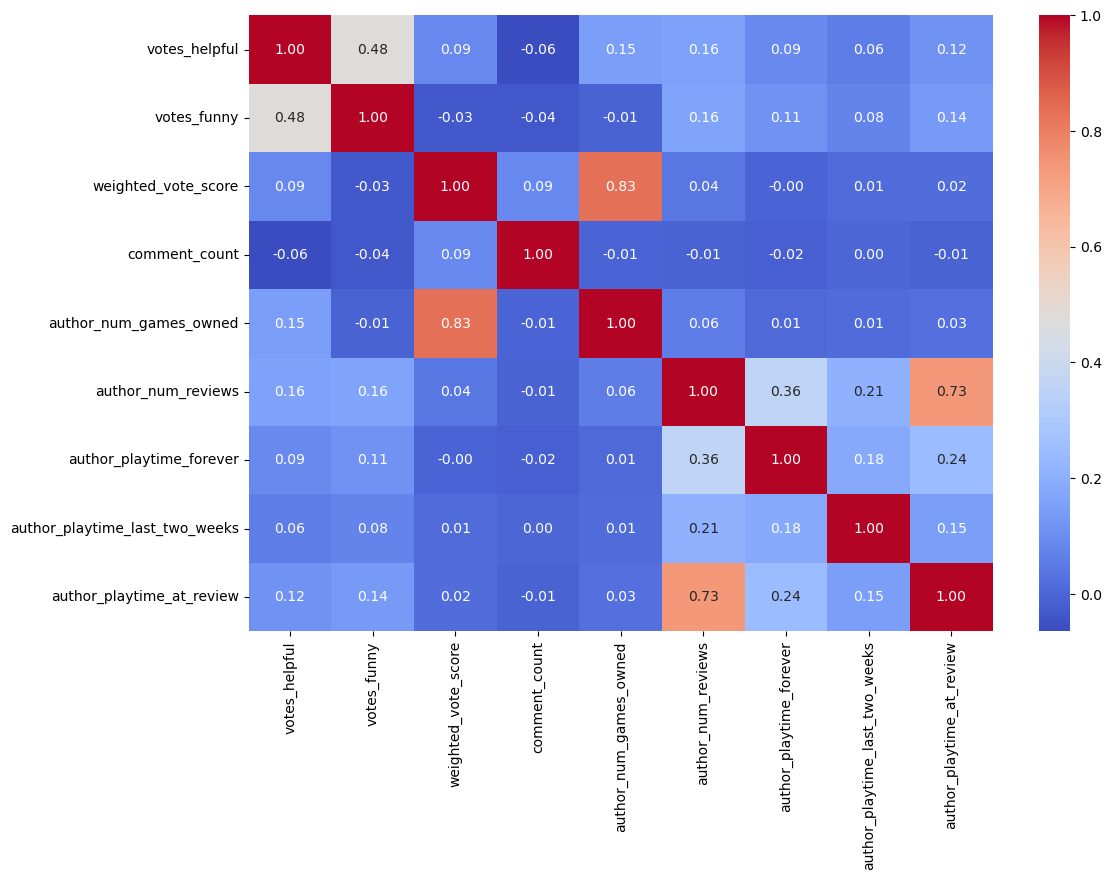

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

continuous_features = [
    "feature_0", "feature_1", "feature_2", "feature_3",
    "feature_4", "feature_5", "feature_6", "feature_7", "feature_8"
]

feature_names_mapping = {
    "feature_0": "votes_helpful",
    "feature_1": "votes_funny",
    "feature_2": "weighted_vote_score",
    "feature_3": "comment_count",
    "feature_4": "author_num_games_owned",
    "feature_5": "author_num_reviews",
    "feature_6": "author_playtime_forever",
    "feature_7": "author_playtime_last_two_weeks",
    "feature_8": "author_playtime_at_review"
}

df_continuous = df_pandas[continuous_features]

df_continuous = df_continuous.rename(columns=feature_names_mapping)

correlation_matrix = df_continuous.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    xticklabels=correlation_matrix.columns,
    yticklabels=correlation_matrix.columns
)



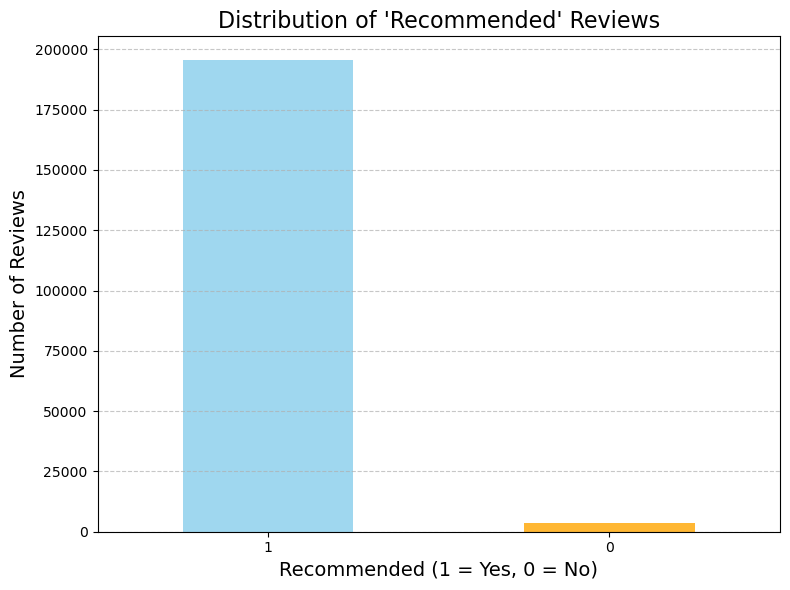

Percentage Distribution of 'Recommended' Reviews:
recommended
1    98.090539
0     1.909461
Name: count, dtype: float64


In [15]:
import matplotlib.pyplot as plt

recommendation_counts = df_pandas["recommended"].value_counts()

plt.figure(figsize=(8, 6))
recommendation_counts.plot(kind='bar', color=['skyblue', 'orange'], alpha=0.8)
plt.title("Distribution of 'Recommended' Reviews", fontsize=16)
plt.xlabel("Recommended (1 = Yes, 0 = No)", fontsize=14)
plt.ylabel("Number of Reviews", fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Percentage Distribution of 'Recommended' Reviews:")
print(recommendation_counts / recommendation_counts.sum() * 100)


In [30]:
from pyspark.ml.classification import LogisticRegression  
trusted_data_path = "gs://steam-reviews-bucket/trusted/steam_reviews_features.parquet"
df_transformed = spark.read.parquet(trusted_data_path)

train_data, test_data = df_transformed.randomSplit([0.7, 0.3], seed=42)

lr = LogisticRegression(featuresCol="features", labelCol="recommended", maxIter=10)
lr_model = lr.fit(train_data)

lr_model_path = "gs://steam-reviews-bucket/models/logistic_regression_model"
lr_model.write().overwrite().save(lr_model_path)
print(f"Logistic Regression model saved at {lr_model_path}")

Logistic Regression model saved at gs://steam-reviews-bucket/models/logistic_regression_model


In [32]:
test_data_path = "gs://steam-reviews-bucket/trusted/test_data.parquet"
test_data.write.mode("overwrite").parquet(test_data_path)

print(f"Test data saved to {test_data_path}")

Test data saved to gs://steam-reviews-bucket/trusted/test_data.parquet


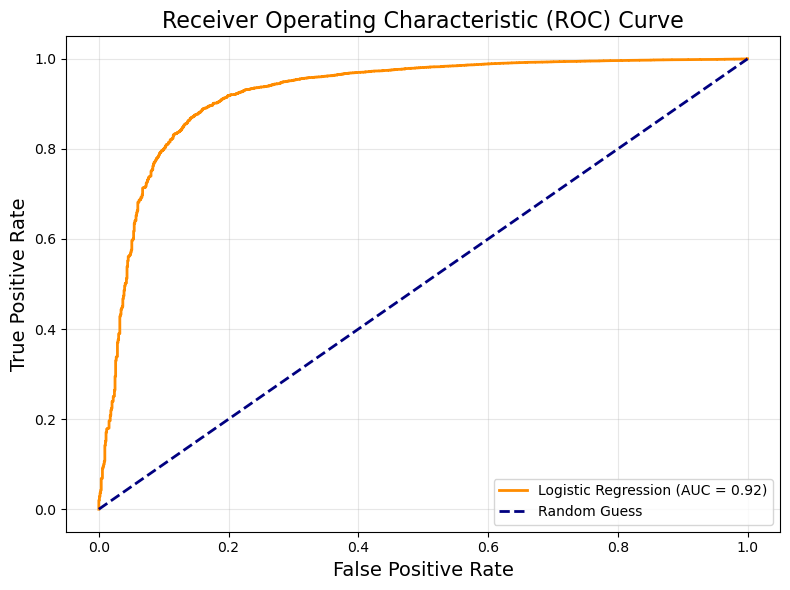

In [33]:
from pyspark.ml.classification import LogisticRegressionModel
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

test_data = spark.read.parquet(test_data_path)

lr_model_path = "gs://steam-reviews-bucket/models/logistic_regression_model"
lr_model = LogisticRegressionModel.load(lr_model_path)

predicted_probabilities = (
    lr_model.transform(test_data)
    .select("probability")
    .rdd.map(lambda x: x[0][1])
    .collect()
)

true_labels = test_data.select("recommended").rdd.map(lambda x: x[0]).collect()

fpr, tpr, _ = roc_curve(true_labels, predicted_probabilities)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"Logistic Regression (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=16)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


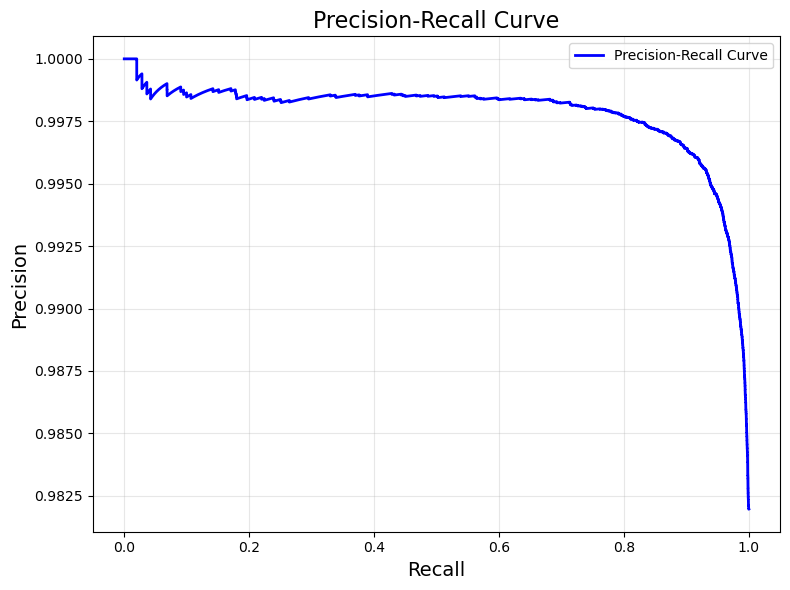

In [34]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

predicted_probabilities = (
    lr_model.transform(test_data)
    .select("probability")
    .rdd.map(lambda x: x[0][1])
    .collect()
)

true_labels = test_data.select("recommended").rdd.map(lambda x: x[0]).collect()

precision, recall, thresholds = precision_recall_curve(true_labels, predicted_probabilities)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="blue", lw=2, label="Precision-Recall Curve")
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Precision-Recall Curve", fontsize=16)
plt.grid(alpha=0.3)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()
